In [1]:
from google.colab import auth
auth.authenticate_user()

In [2]:
!git config --global user.name "MechaPichanon"
!git config --global user.email "frankenstien205@gmail.com"

In [3]:
!git init
!git remote add origin https://github.com/MechaPichanon/Kaggle_HumpbackWhale.git

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/


In [4]:
!ls

sample_data


In [5]:
!git add Kaggle_Whale.ipynb

fatal: pathspec 'Kaggle_Whale.ipynb' did not match any files


In [ ]:
!pip install kaggle

In [ ]:
!mkdir /.kaggle
!mv kaggle.json /.kaggle
!mv /.kaggle /root/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c humpback-whale-identification

100% 5.50G/5.51G [04:20<00:00, 28.5MB/s]
100% 5.51G/5.51G [04:20<00:00, 22.7MB/s]


In [ ]:
!unzip /content/humpback-whale-identification.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/cd2c4ae6b.jpg     
  inflating: train/cd310f07c.jpg     
  inflating: train/cd32697ae.jpg     
  inflating: train/cd346388a.jpg     
  inflating: train/cd36f1901.jpg     
  inflating: train/cd382b662.jpg     
  inflating: train/cd3937f27.jpg     
  inflating: train/cd3a073a2.jpg     
  inflating: train/cd3afe416.jpg     
  inflating: train/cd407fae0.jpg     
  inflating: train/cd437a15c.jpg     
  inflating: train/cd444321e.jpg     
  inflating: train/cd4740ee9.jpg     
  inflating: train/cd49e7801.jpg     
  inflating: train/cd4b8f33f.jpg     
  inflating: train/cd4fae084.jpg     
  inflating: train/cd520d861.jpg     
  inflating: train/cd52c565c.jpg     
  inflating: train/cd5577b32.jpg     
  inflating: train/cd5712905.jpg     
  inflating: train/cd598b557.jpg     
  inflating: train/cd59d5874.jpg     
  inflating: train/cd5a9c5b1.jpg     
  inflating: train/cd5b23ddc.jpg     
  inflating: train/cd5dd712e.jpg     

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.losses import CategoricalCrossentropy
import pandas as pd
import numpy as np
import os
import shutil
from tensorflow.keras.models import load_model

In [ ]:
# Paths
source_folder = 'train'
train_dir = 'train_dir'
output_dir = 'output_dir'
os.makedirs(output_dir, exist_ok=True)
os.makedirs(train_dir, exist_ok=True)

# Create subdirectories for training
label_csv_path = 'train.csv'
labels_df = pd.read_csv(label_csv_path)



# Map class indices to actual whale IDs
class_indices = {v: k for k, v in train_generator.class_indices.items()}

# Organize images into class directories
for _, row in labels_df.iterrows():
    image_name = row['Image']
    class_label = row['Id']

    class_path = os.path.join(train_dir, str(class_label))
    os.makedirs(class_path, exist_ok=True)

    src_image_path = os.path.join(source_folder, image_name)
    dest_image_path = os.path.join(class_path, image_name)

    if os.path.exists(src_image_path):
        shutil.copy(src_image_path, dest_image_path)

print("Images organized into class directories.")

Images organized into class directories.


In [ ]:
# Load and prepare the model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Define the model with the correct number of classes from train_generator
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(train_generator.num_classes, activation='softmax')  # Ensure num_classes is correctly set
])

# Loss function with label smoothing
loss_fn = CategoricalCrossentropy(label_smoothing=0.1)
model.compile(optimizer=Adam(learning_rate=1e-3), loss=loss_fn, metrics=['accuracy'])

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', subset='validation'
)

Found 22016 images belonging to 5005 classes.
Found 3345 images belonging to 5005 classes.


In [ ]:
# Callbacks
callbacks = [
    ModelCheckpoint(filepath=os.path.join(output_dir, 'best_model.keras'), save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
    TensorBoard(log_dir=os.path.join(output_dir, 'logs'))
]

In [ ]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,
    callbacks=callbacks
)

model.save('whale_ver1.keras')

Epoch 1/5
688/688 [==============================] - 524s 760ms/step - loss: 6.5921 - accuracy: 0.3512 - val_loss: 5.2335 - val_accuracy: 0.5776 - lr: 0.0010
Epoch 2/5
688/688 [==============================] - 526s 765ms/step - loss: 6.5755 - accuracy: 0.3512 - val_loss: 4.7142 - val_accuracy: 0.5776 - lr: 0.0010
Epoch 3/5
688/688 [==============================] - 534s 776ms/step - loss: 6.5350 - accuracy: 0.3512 - val_loss: 4.4427 - val_accuracy: 0.5776 - lr: 0.0010
Epoch 4/5
688/688 [==============================] - 526s 764ms/step - loss: 6.5010 - accuracy: 0.3512 - val_loss: 4.3568 - val_accuracy: 0.5776 - lr: 0.0010
Epoch 5/5
688/688 [==============================] - 530s 770ms/step - loss: 6.4699 - accuracy: 0.3512 - val_loss: 4.4879 - val_accuracy: 0.5776 - lr: 0.0010


In [ ]:
model_path = 'whale_ver1.keras'
model = load_model(model_path)

In [ ]:
#Load test data and make predictions
# Replace 'test_dir' with the path to your test images
test_dir = 'test'
os.makedirs(os.path.join(test_dir, 'test_images'), exist_ok=True)

# Move images into the 'test_images' subdirectory if needed
for image in os.listdir(test_dir):
    if image.endswith(('.jpg', '.png')) and os.path.isfile(os.path.join(test_dir, image)):
        shutil.move(os.path.join(test_dir, image), os.path.join(test_dir, 'test_images', image))

# Create test generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

predictions = model.predict(test_generator)

# Map class indices to whale IDs
class_indices = {v: k for k, v in train_generator.class_indices.items()}
top_5_indices = np.argsort(predictions, axis=1)[:, -5:][:, ::-1]

# Convert predicted indices to class labels, handling any unknown indices
top_5_ids = []
for top_5 in top_5_indices:
    top_5_labels = []
    for idx in top_5:
        # Use 'unknown' as a placeholder if index is missing in class_indices
        top_5_labels.append(class_indices.get(idx, "unknown"))
    top_5_ids.append(top_5_labels)

# Prepare the submission DataFrame
filenames = test_generator.filenames
image_ids = [os.path.basename(f) for f in filenames]
results = pd.DataFrame({
    'Image': image_ids,
    'Id': [' '.join(top_5) for top_5 in top_5_ids]
})
results.to_csv(os.path.join(output_dir, '3_submission.csv'), index=False)

print("Submission file with top 5 whale IDs saved!")

Found 7960 images belonging to 1 classes.
249/249 [==============================] - 138s 548ms/step
Submission file with top 5 whale IDs saved!


105/105 [==============================] - 71s 669ms/step


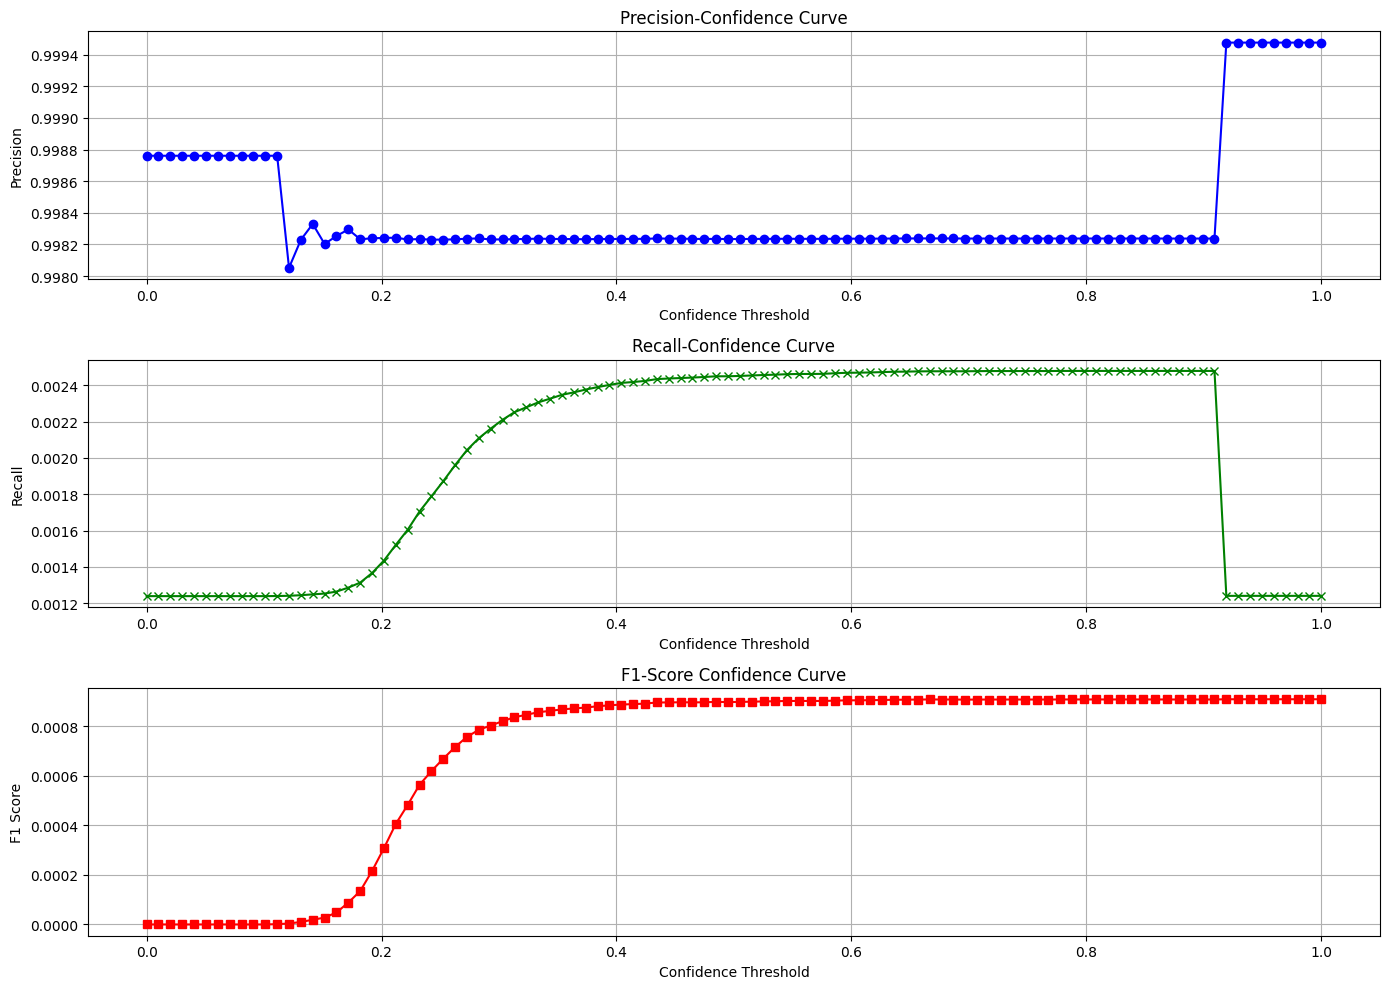

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

y_true = validation_generator.classes  # True class indices from validation generator
predictions = model.predict(validation_generator)
y_pred_probs = np.max(predictions, axis=1)  # Maximum probability for the predicted class

# Define confidence thresholds
confidence_thresholds = np.linspace(0, 1, 100)
precision_scores = []
recall_scores = []
f1_scores = []

# Calculate precision, recall, and F1-score for each threshold
for threshold in confidence_thresholds:
    # Convert probabilities to binary predictions based on the current threshold
    y_pred = (y_pred_probs >= threshold).astype(int)

    # Calculate precision, recall, and F1-score
    precision = precision_score(y_true, y_pred, average='macro', zero_division=1)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=1)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=1)

    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Plot each metric separately
plt.figure(figsize=(14, 10))

# Precision-Confidence Curve
plt.subplot(3, 1, 1)
plt.plot(confidence_thresholds, precision_scores, marker='o', color='b')
plt.title("Precision-Confidence Curve")
plt.xlabel("Confidence Threshold")
plt.ylabel("Precision")
plt.grid(True)

# Recall-Confidence Curve
plt.subplot(3, 1, 2)
plt.plot(confidence_thresholds, recall_scores, marker='x', color='g')
plt.title("Recall-Confidence Curve")
plt.xlabel("Confidence Threshold")
plt.ylabel("Recall")
plt.grid(True)

# F1-Score Confidence Curve
plt.subplot(3, 1, 3)
plt.plot(confidence_thresholds, f1_scores, marker='s', color='r')
plt.title("F1-Score Confidence Curve")
plt.xlabel("Confidence Threshold")
plt.ylabel("F1 Score")
plt.grid(True)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

In [ ]:
!pip install -q streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 91.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 kB 5.4 MB/s eta 0:00:00


In [ ]:
!npm install -g localtunnel


added 22 packages, and audited 23 packages in 4s

3 packages are looking for funding
  run `npm fund` for details

1 moderate severity vulnerability

To address all issues (including breaking changes), run:
  npm audit fix --force

Run `npm audit` for details.


In [ ]:
!npm audit fix --force

npm WARN using --force Recommended protections disabled.
npm ERR! code ENOLOCK
npm ERR! audit This command requires an existing lockfile.
npm ERR! audit Try creating one first with: npm i --package-lock-only
npm ERR! audit Original error: loadVirtual requires existing shrinkwrap file

npm ERR! A complete log of this run can be found in:
npm ERR!     /root/.npm/_logs/2024-11-07T16_07_37_205Z-debug-0.log


In [ ]:
%%writefile app.py
import streamlit as st
st.write('# test')

Writing app.py


In [ ]:
# prompt: สร้างเว็ปแอปจากstearmlit โดยเขียนลงไฟล์app.pyเพื่อนำไปเปิดเว็ป โดยมีการอัพโหลดรูปเพื่อทายรูปภาพนั้นเหมือนภาพไหนมากที่สุด5ภาพโดย5ภาพให้บอกidของแต่ละภาพมาไม่ต้องนำภาพมาแสดง

%%writefile app.py
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.losses import CategoricalCrossentropy
import pandas as pd
import numpy as np
import os
import shutil
import streamlit as st
from PIL import Image
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import os

# Load the pre-trained model
model_path = 'Resnet50Model_2.keras'  # Replace with the actual path to your model
model = load_model(model_path)

# Function to preprocess the image
def preprocess_image(img):
    img = img.resize((224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.
    return img_array

# Streamlit app
st.title("Whale Image Classifier")

uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    img = Image.open(uploaded_file)
    st.image(img, caption="Uploaded Image", use_column_width=True)

    img_array = preprocess_image(img)
    predictions = model.predict(img_array)

    # Get top 5 predictions
    top_5_indices = np.argsort(predictions[0])[-5:][::-1]

    # Assuming you have a mapping from class indices to whale IDs
    #  (replace 'class_indices' with your actual mapping)
    try:
        class_indices = {v: k for k, v in train_generator.class_indices.items()}
    except NameError:
        st.error("Error: 'train_generator' not defined. Please ensure you have run the training part of the code and have the class_indices mapping created.")
        st.stop()  # Stop execution if class_indices are not available

    top_5_ids = []
    for index in top_5_indices:
        whale_id = class_indices.get(index, "Unknown")
        top_5_ids.append(whale_id)


    st.write("Top 5 Predicted Whale IDs:")
    for whale_id in top_5_ids:
        st.write(whale_id)

Overwriting app.py


In [ ]:
# prompt: รันเว็ปแอป

!streamlit run /content/app.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.81.131.223:8501

your url is: https://cold-things-cover.loca.lt
2024-11-07 17:50:16.175944: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-07 17:50:16.472118: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-07 17:50:16.561841: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-07 17:50:19.080068: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-11-07 17:50:2

In [ ]:
# prompt: สร้างเว็ปแอปจากstearmlit
%%writefile app.py
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming your model and other necessary files are in the same directory
# Replace 'output_dir' with the actual path if needed
output_dir = 'output_dir'

# Function to display the image
def display_image(image_path):
    try:
        img = Image.open(image_path)
        st.image(img, caption=f"Uploaded Image", use_column_width=True)
    except FileNotFoundError:
        st.error("Image not found.")


st.title("Whale Identification App")

# Upload image through Streamlit
uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    image_path = "uploaded_image.jpg"  # Save the image temporarily
    with open(image_path, "wb") as f:
        f.write(uploaded_file.getbuffer())
    display_image(image_path)


    # Add prediction button
    if st.button("Predict Whale"):
        try:
            # Load the model (replace with the actual loading of your model)
            test_dir = '/content/uploaded_image.jpg'
            test_datagen = ImageDataGenerator(rescale=1./255)
            test_generator = test_datagen.flow_from_directory(
              test_dir,
              target_size=(224, 224),
              batch_size=32,
              class_mode=None,
              shuffle=False
          )
            predictions = model.predict(test_generator)
            # Perform prediction on the uploaded image
            # Replace this with your actual prediction logic
            # Example: prediction = model.predict(image_path)
            st.write("Prediction Logic (replace with your model loading and prediction code)")

            # Placeholder for prediction results
            # Replace this with your actual prediction result
            prediction = "Placeholder prediction"

            st.write(f"Predicted Whale ID: {prediction}")
        except Exception as e:
            st.error(f"Error during prediction: {e}")

    # Display evaluation metrics
    st.subheader("Evaluation Metrics")
    try:
        # Load the evaluation metrics plots
        # Assuming you have saved the plot images as 'precision_plot.png', etc.
        precision_plot_path = os.path.join(output_dir, "precision_plot.png")
        recall_plot_path = os.path.join(output_dir, "recall_plot.png")
        f1_plot_path = os.path.join(output_dir, "f1_plot.png")

        if os.path.exists(precision_plot_path):
            st.image(precision_plot_path, caption="Precision-Confidence Curve", use_column_width=True)
        else:
            st.warning("Precision plot not found.")

        if os.path.exists(recall_plot_path):
            st.image(recall_plot_path, caption="Recall-Confidence Curve", use_column_width=True)
        else:
            st.warning("Recall plot not found.")

        if os.path.exists(f1_plot_path):
            st.image(f1_plot_path, caption="F1-Score Confidence Curve", use_column_width=True)
        else:
            st.warning("F1 plot not found.")

    except Exception as e:
        st.error(f"Error displaying evaluation plots: {e}")


    # Optionally:  Display the submission file (3_submission.csv)
    submission_file_path = os.path.join(output_dir, '3_submission.csv')
    if os.path.exists(submission_file_path):
        try:
            submission_df = pd.read_csv(submission_file_path)
            st.write("Submission File:")
            st.dataframe(submission_df)
        except Exception as e:
            st.error(f"Error displaying submission file: {e}")
    else:
        st.warning("Submission file not found.")


Overwriting app.py
